In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [4]:
from torch.utils.data import DataLoader, Dataset

In [5]:
class WikiDataset(Dataset):

    def __init__(self, images, genders, ages, transforms=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = images
        self.genders = genders
        self.ages = ages
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
        data = self.images.iloc[i, :]
        data = np.asarray(data).astype(np.uint8).reshape(100, 100, 1)
        
        if self.transforms:
            data = self.transforms(data)
            
        return (data, self.genders[i], self.ages[i]) # returns a tuple

In [6]:
train_data = pd.read_csv('data/wiki5.csv')

train_images = train_data.iloc[:, 3:]
train_genders = train_data.iloc[:, 1]
train_ages = train_data.iloc[:, 2]

In [7]:
train_set = WikiDataset(train_images, train_genders, train_ages, transforms.Compose([
        transforms.ToTensor()
    ]))

In [8]:
print(train_set[0]) 
print(type(train_set[0][0]))
print(type(train_set[0][1]))
print(type(train_set[0][2]))
print(train_set[0][0].shape)
len(train_set)

(tensor([[[0.6824, 0.6784, 0.6745,  ..., 0.6314, 0.6314, 0.6275],
         [0.6784, 0.6745, 0.6745,  ..., 0.6353, 0.6314, 0.6314],
         [0.6706, 0.6706, 0.6706,  ..., 0.6353, 0.6314, 0.6196],
         ...,
         [0.6902, 0.6941, 0.6941,  ..., 0.1059, 0.1137, 0.1137],
         [0.7020, 0.6902, 0.6863,  ..., 0.1137, 0.1137, 0.1137],
         [0.6941, 0.6863, 0.6980,  ..., 0.1255, 0.1216, 0.1137]]]), 1, 36)
<class 'torch.Tensor'>
<class 'numpy.int64'>
<class 'numpy.int64'>
torch.Size([1, 100, 100])


3209

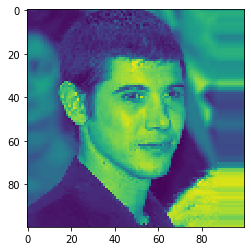

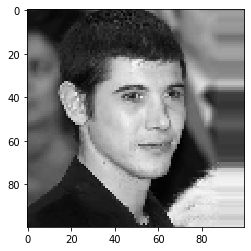

In [9]:
plt.figure()
plt.imshow(train_set[3000][0].squeeze()) # squeeze() is same as reshape(100,100)
plt.show()

plt.imshow(train_set[3000][0].reshape(100,100), cmap='gray') 

In [10]:


batch = next(iter(train_loader))
print(len(batch))

images, genders, ages = batch
print(type(images), type(genders), type(ages))
print(images.shape, genders.shape, ages.shape)

print(images[0].shape)
print(genders[0], ages[0])

3
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([128, 1, 100, 100]) torch.Size([128]) torch.Size([128])
torch.Size([1, 100, 100])
tensor(1) tensor(28)


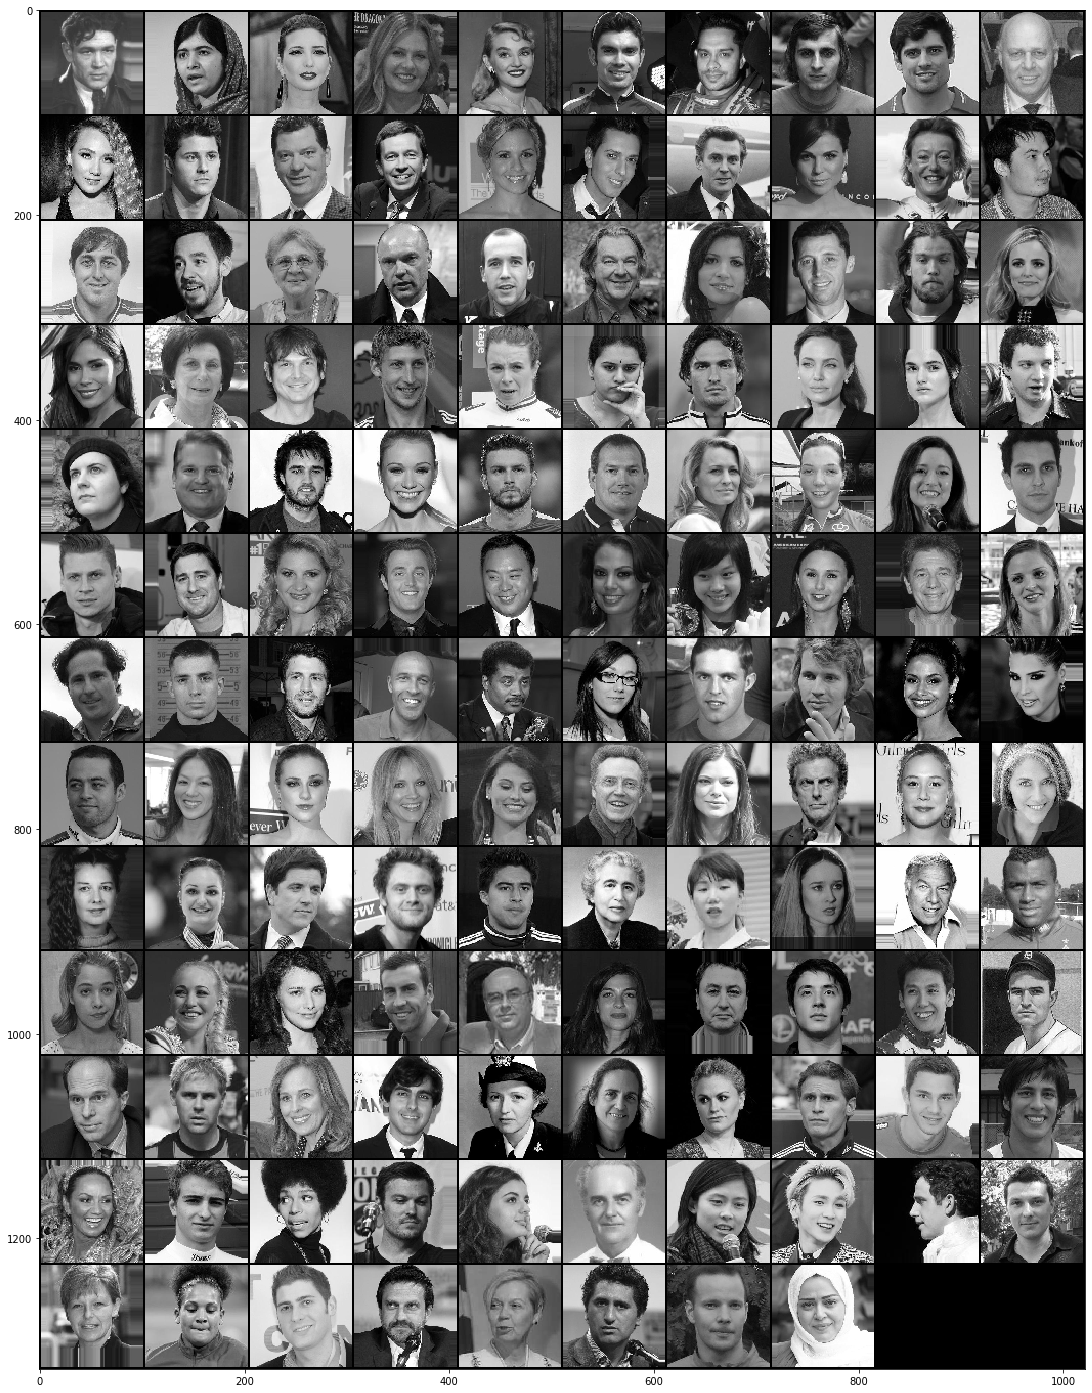

In [11]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(25,25))
plt.imshow(grid.permute(1,2,0))

In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12 * 22 * 22, out_features=120) # linear layer is also called as fully connected layer 
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=2)
    
    def forward(self, t):
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 22 * 22)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)

        return t

In [1]:
network = Network()

preds = network(images[0].unsqueeze(0)) # passing single image to network
print(preds.shape)
print(F.softmax(preds, dim=1)) # to get probabilities
print(F.softmax(preds, dim=1).sum())

preds = network(images) # passing batch of images to network
print(preds.shape)
print(F.softmax(preds, dim=1))
print(F.softmax(preds, dim=1).sum())

NameError: name 'Network' is not defined

In [16]:
get_num_correct(preds, genders)

54

In [17]:
loss = F.cross_entropy(preds, genders) # Calculating the loss

loss.item()

0.6935086846351624

In [20]:
print(network.conv1.weight.grad) #  verify that we currently have no gradients inside our conv1 layer

tensor([[[[-1.3369e-05, -1.7277e-05, -2.2394e-05, -8.7950e-06, -1.5875e-06],
          [-8.2609e-07, -3.8522e-05, -4.4435e-05, -9.4103e-06, -1.4196e-06],
          [-1.6879e-05, -2.3720e-05, -2.7680e-05, -7.4986e-06, -9.0228e-06],
          [-1.1754e-05, -1.3304e-05, -2.0039e-05, -6.4095e-06, -1.4597e-06],
          [-2.0255e-05, -4.3303e-06, -1.9532e-05, -1.0731e-05, -7.4451e-06]]],


        [[[ 7.6192e-04,  8.1939e-04,  7.9416e-04,  7.4917e-04,  8.0797e-04],
          [ 7.5748e-04,  8.0991e-04,  8.1961e-04,  7.8174e-04,  7.3690e-04],
          [ 7.1270e-04,  7.5795e-04,  8.8472e-04,  7.7621e-04,  7.6457e-04],
          [ 8.2898e-04,  8.5066e-04,  7.6451e-04,  7.3542e-04,  7.9246e-04],
          [ 8.3322e-04,  8.3059e-04,  7.5464e-04,  7.2701e-04,  7.7438e-04]]],


        [[[ 3.6570e-04,  3.9967e-04,  2.9497e-04,  2.6979e-04,  1.0604e-04],
          [ 4.1060e-04,  3.1994e-04,  2.8931e-04,  2.9955e-04,  2.2281e-04],
          [ 3.1477e-04,  4.0809e-04,  3.5231e-04,  3.0483e-04,  3.56

In [19]:
loss.backward() # Calculating the gradients and storing in grad attribute

print(network.conv1.weight.grad.shape)

torch.Size([6, 1, 5, 5])


In [21]:
optimizer = optim.Adam(network.parameters(), lr=0.0001)
optimizer.step() # Updating the weights

In [22]:
preds = network(images) # passing the same batch of 128 images just to check, whether loss in minimized and no. of correct outputs are                                      #maximized

loss = F.cross_entropy(preds, genders) # Calculating the loss

print(loss.item())

0.69144606590271


In [23]:
get_num_correct(preds, genders)

70

In [24]:
print(preds.argmax(dim=1))
print(genders)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 0])


In [9]:
torch.set_grad_enabled(True)

In [10]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [13]:
network = Network()

optimizer = optim.Adam(network.parameters(), lr=0.01)

train_loader = torch.utils.data.DataLoader(
    train_set
    ,batch_size=50
    ,shuffle=True
)

In [14]:
optimizer.zero_grad()

for epoch in range(12):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, genders, ages = batch

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, genders) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, genders)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: 1863 loss: 45.32170790433884
epoch 1 total_correct: 2231 loss: 37.5526502430439
epoch 2 total_correct: 2415 loss: 32.68502753973007
epoch 3 total_correct: 2521 loss: 29.548564970493317
epoch 4 total_correct: 2560 loss: 28.535287588834763
epoch 5 total_correct: 2671 loss: 24.286472134292126
epoch 6 total_correct: 2716 loss: 23.2542667388916
epoch 7 total_correct: 2723 loss: 22.441185384988785
epoch 8 total_correct: 2816 loss: 18.655166819691658
epoch 9 total_correct: 2888 loss: 15.904377743601799
epoch 10 total_correct: 2915 loss: 14.274775743484497
epoch 11 total_correct: 2953 loss: 12.018535867333412


In [44]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    all_genders = torch.tensor([], dtype=float)
    for batch in loader:
        images, genders, ages = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_genders = torch.cat(
            (all_genders, genders.type(torch.DoubleTensor))
            ,dim=0
        )
    return (all_preds, all_genders)


prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=1000)
train_preds, all_genders = get_all_preds(network, prediction_loader)



preds_correct = get_num_correct(train_preds, all_genders)
print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(train_set))

total correct: 2897
accuracy: 0.9027734496727953


<class 'numpy.ndarray'>
Confusion matrix, without normalization
[[1079  300]
 [  12 1818]]


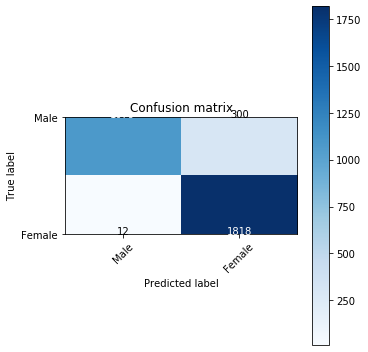

In [17]:
# code to plot confusion matrix

from plotcm import plot_confusion_matrix

names = (
    'Male'
    ,'Female'
)

cm = confusion_matrix(all_genders, train_preds.argmax(dim=1))
print(type(cm))
cm

plt.figure(figsize=(5,5))
plot_confusion_matrix(cm, names)

In [19]:
# testing part 1

torch.set_grad_enabled(False)

sample = next(iter(train_loader))
ima, gen, ag = sample
print(ima)

tensor([[[[0.1490, 0.1490, 0.1490,  ..., 0.7098, 0.6980, 0.6863],
          [0.1490, 0.1490, 0.1490,  ..., 0.7294, 0.7216, 0.7137],
          [0.1490, 0.1490, 0.1490,  ..., 0.7686, 0.7725, 0.7686],
          ...,
          [0.3059, 0.2784, 0.2980,  ..., 0.0549, 0.0471, 0.0588],
          [0.2745, 0.2784, 0.3020,  ..., 0.0549, 0.0471, 0.0588],
          [0.2980, 0.2902, 0.3059,  ..., 0.0510, 0.0549, 0.0471]]],


        [[[0.6039, 0.6039, 0.6039,  ..., 0.6039, 0.6039, 0.6039],
          [0.6039, 0.6039, 0.6039,  ..., 0.6078, 0.6078, 0.6078],
          [0.6039, 0.6039, 0.6039,  ..., 0.6118, 0.6118, 0.6118],
          ...,
          [0.2824, 0.2824, 0.2824,  ..., 0.3020, 0.3020, 0.3020],
          [0.2431, 0.2431, 0.2431,  ..., 0.2588, 0.2588, 0.2588],
          [0.2980, 0.2980, 0.2980,  ..., 0.2627, 0.2627, 0.2627]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

In [35]:
# testing part 2

ima.shape
ima[5].shape
print(gen[5].item())

preds_test = network(ima[5].unsqueeze(0))
print(preds_test)

0
tensor([[ 1.1628, -0.9071]])


In [52]:
# now, how to get gender of a person?

# 1. convert your image into (100, 100) pixels and pass it to your network
# 2. get the predictions tensor and call argmax to get index with max value
# 3. if index is 0, female, elif index is 1, male

In [43]:
from PIL import Image 
  
# creating a image object 
im = Image.open(r"data/leave.jpg")
px = transforms.ToTensor()
px = px(im)



print(px.shape) 
print(px)
print(px[0,:,:])

torch.Size([3, 224, 300])
tensor([[[0.5020, 0.5059, 0.5020,  ..., 0.0824, 0.0824, 0.0824],
         [0.5059, 0.5059, 0.5020,  ..., 0.0824, 0.0824, 0.0824],
         [0.5059, 0.5059, 0.5020,  ..., 0.0824, 0.0824, 0.0824],
         ...,
         [0.1059, 0.1098, 0.1176,  ..., 0.0353, 0.0235, 0.0157],
         [0.1137, 0.1176, 0.1216,  ..., 0.0471, 0.0353, 0.0275],
         [0.1176, 0.1216, 0.1216,  ..., 0.0627, 0.0471, 0.0431]],

        [[0.3922, 0.3961, 0.4000,  ..., 0.4706, 0.4745, 0.4745],
         [0.3961, 0.3961, 0.4000,  ..., 0.4706, 0.4706, 0.4745],
         [0.3961, 0.3961, 0.4039,  ..., 0.4706, 0.4706, 0.4745],
         ...,
         [0.6118, 0.6157, 0.6196,  ..., 0.4157, 0.3961, 0.3882],
         [0.6196, 0.6196, 0.6235,  ..., 0.4275, 0.4118, 0.4039],
         [0.6196, 0.6235, 0.6235,  ..., 0.4471, 0.4275, 0.4196]],

        [[0.1961, 0.2000, 0.2000,  ..., 0.0039, 0.0000, 0.0000],
         [0.2000, 0.2000, 0.2000,  ..., 0.0039, 0.0039, 0.0000],
         [0.2000, 0.2000, 0.1922